In [25]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting_and_analysis import plot_utils, summary_plots, spatial_fits, analysis_utils
plot_utils.set_plotting_defaults()

In [30]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'texture_gabor_ridge_4ori_4sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = analysis_utils.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
analysis_utils.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/texture_gabor_ridge_4ori_4sf/Sep-21-2021_0146_13/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'feature_info', 'nonlin_fn', 'padding_mode', 'autocorr_output_pix', 'group_all_hl_feats'])
subject = 1
volume_space = 1
fitting_type = gabor_texture
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (7500,)
voxel_index: len 1
voxel_roi: len 2
voxel_ncsnr: shape (699192,)
aperture = 1.0
apertu

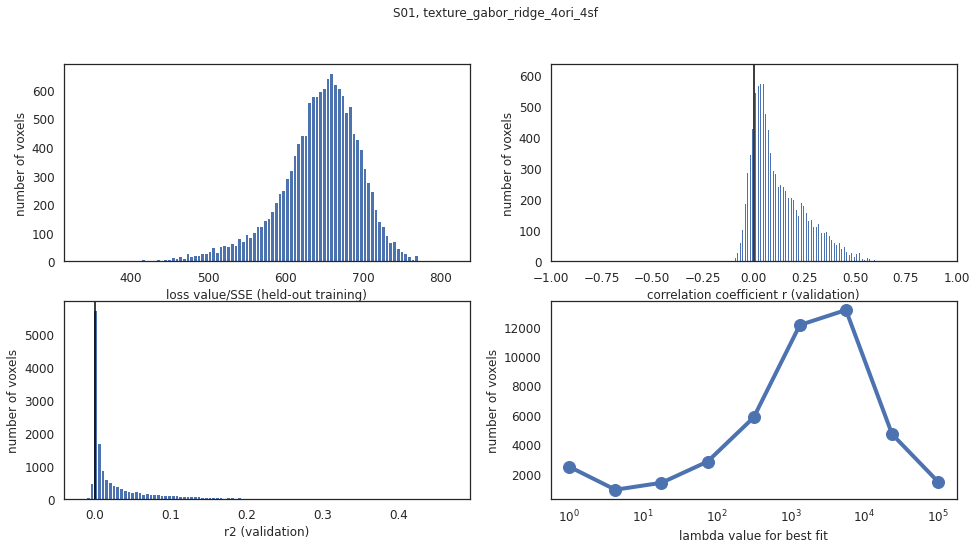

In [19]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [6]:
# plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

In [3]:
summary_plots.plot_summary_pycortex(subject, fitting_type, out, port=33333)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333
Stopping server


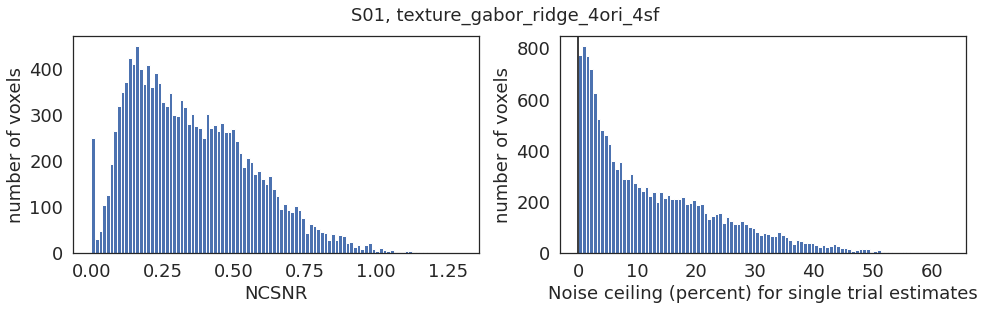

In [20]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

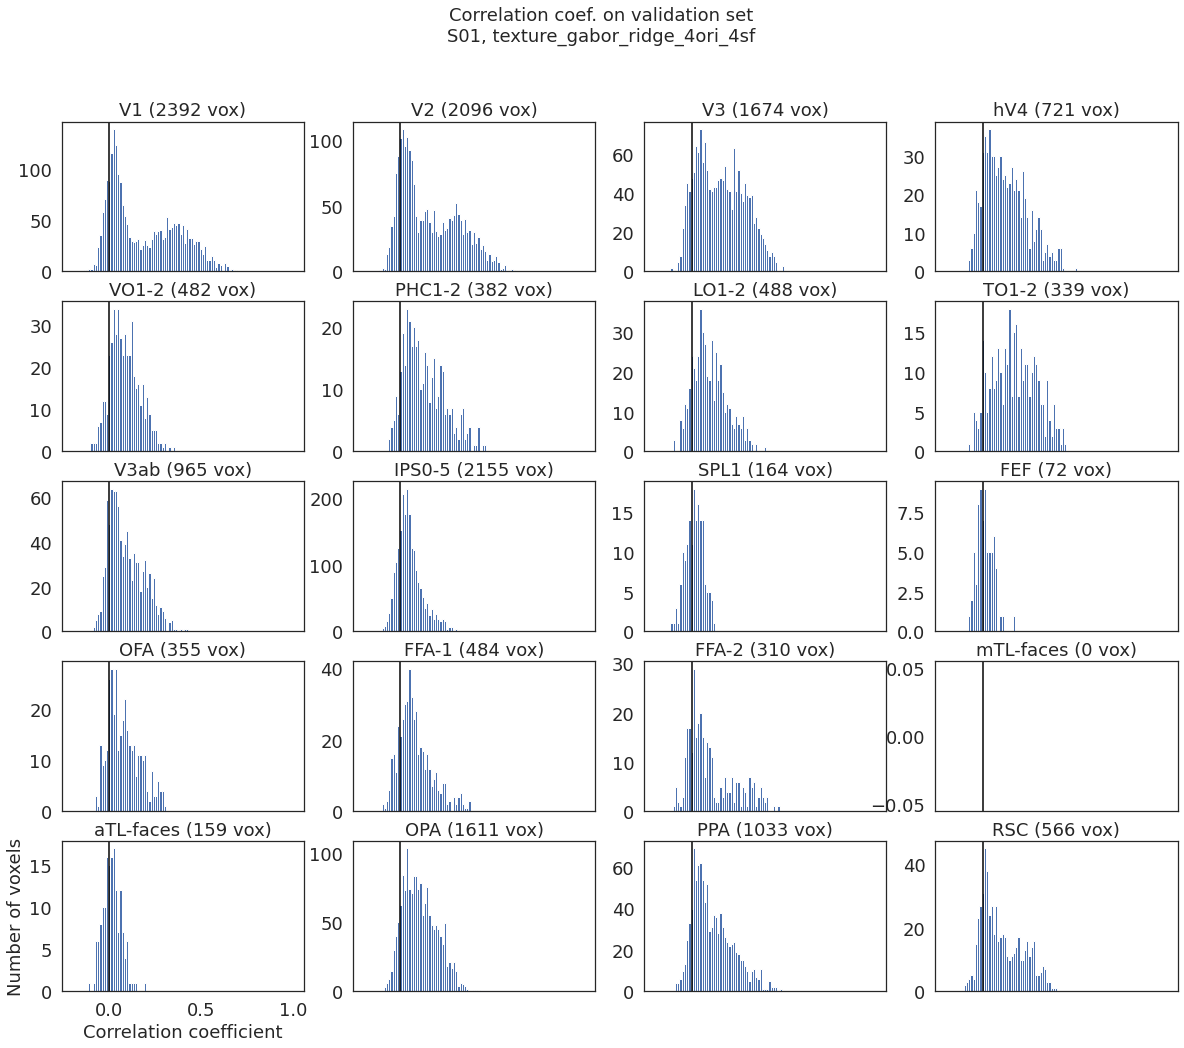

In [21]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_cc_each_roi(subject, fitting_type,out, fig_save_folder)

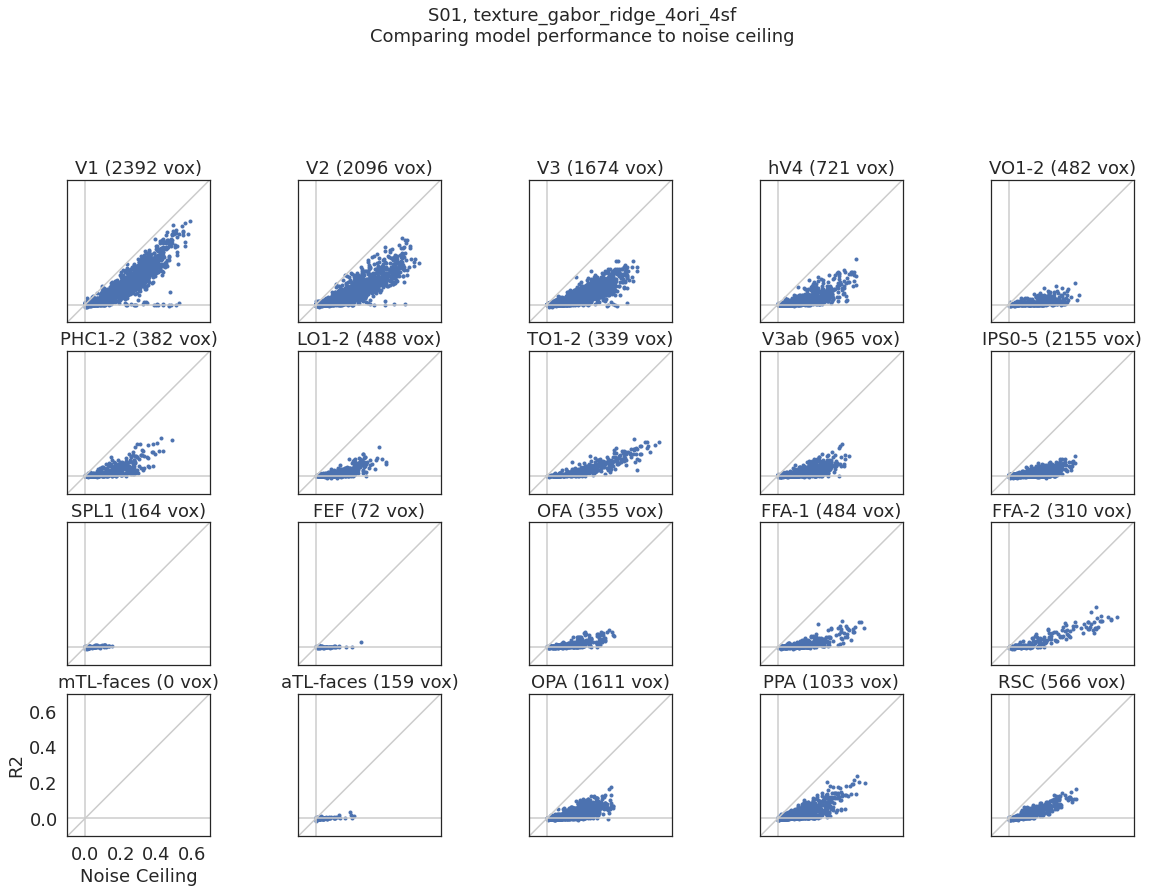

In [22]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_type,out, fig_save_folder, fig_size=(20,24))

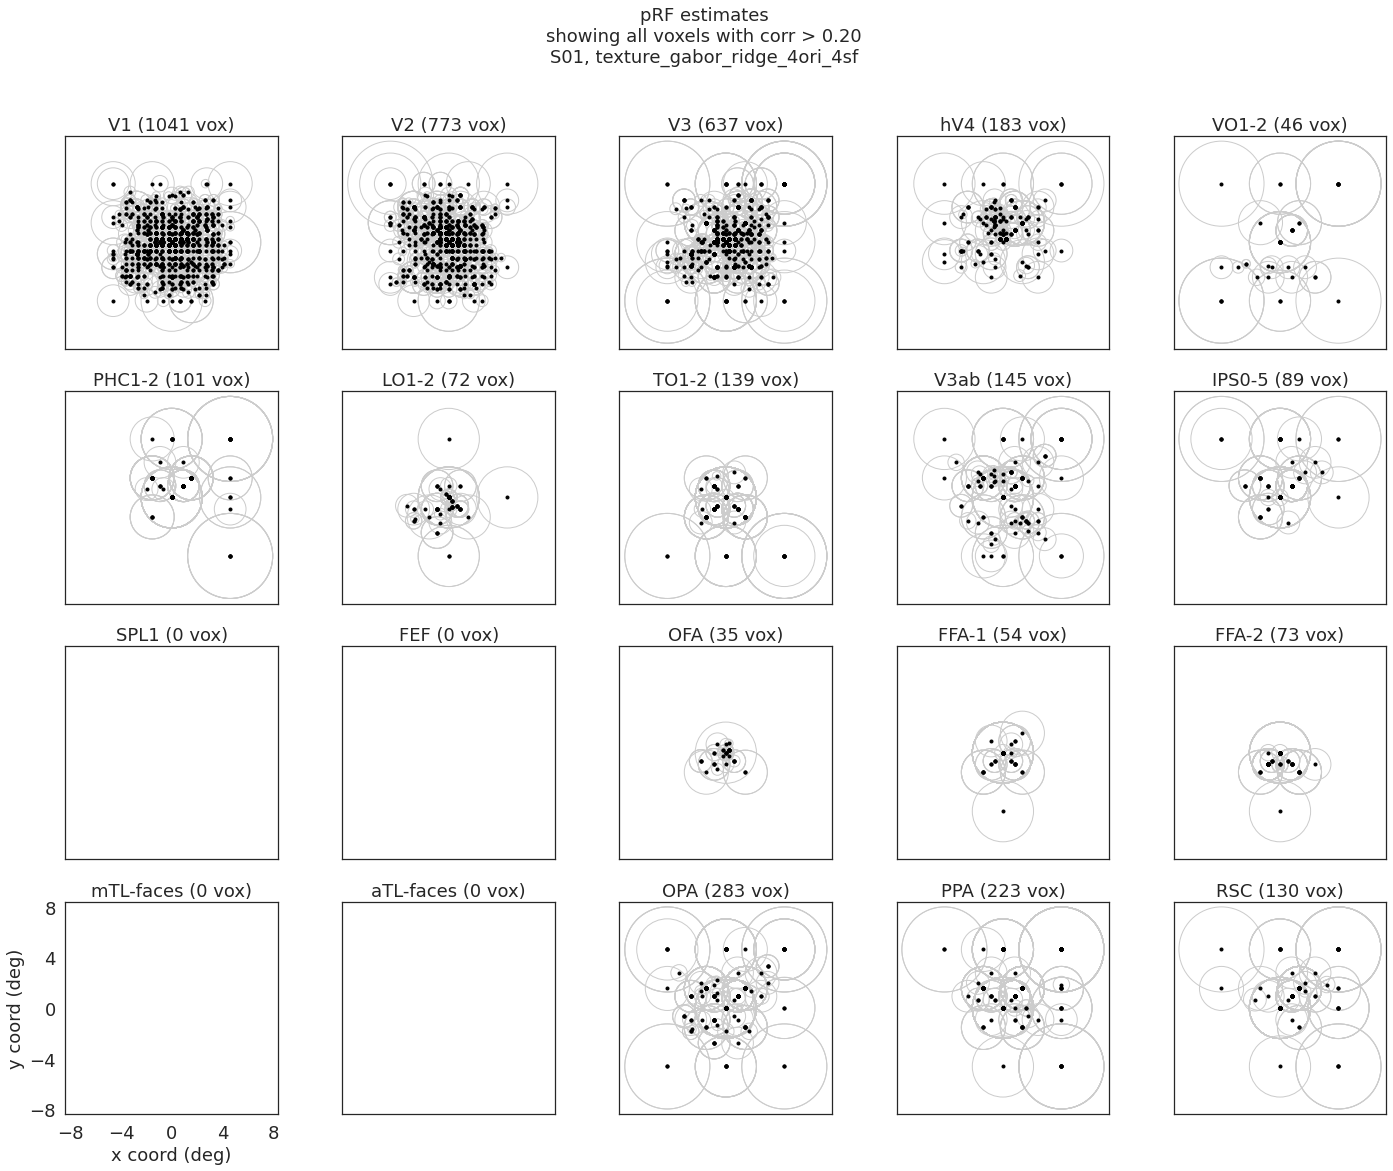

In [23]:
plot_utils.set_all_font_sizes(fs = 18)
spatial_fits.plot_spatial_rf_circles(subject, fitting_type,out, cc_cutoff = 0.20, fig_save_folder=fig_save_folder)

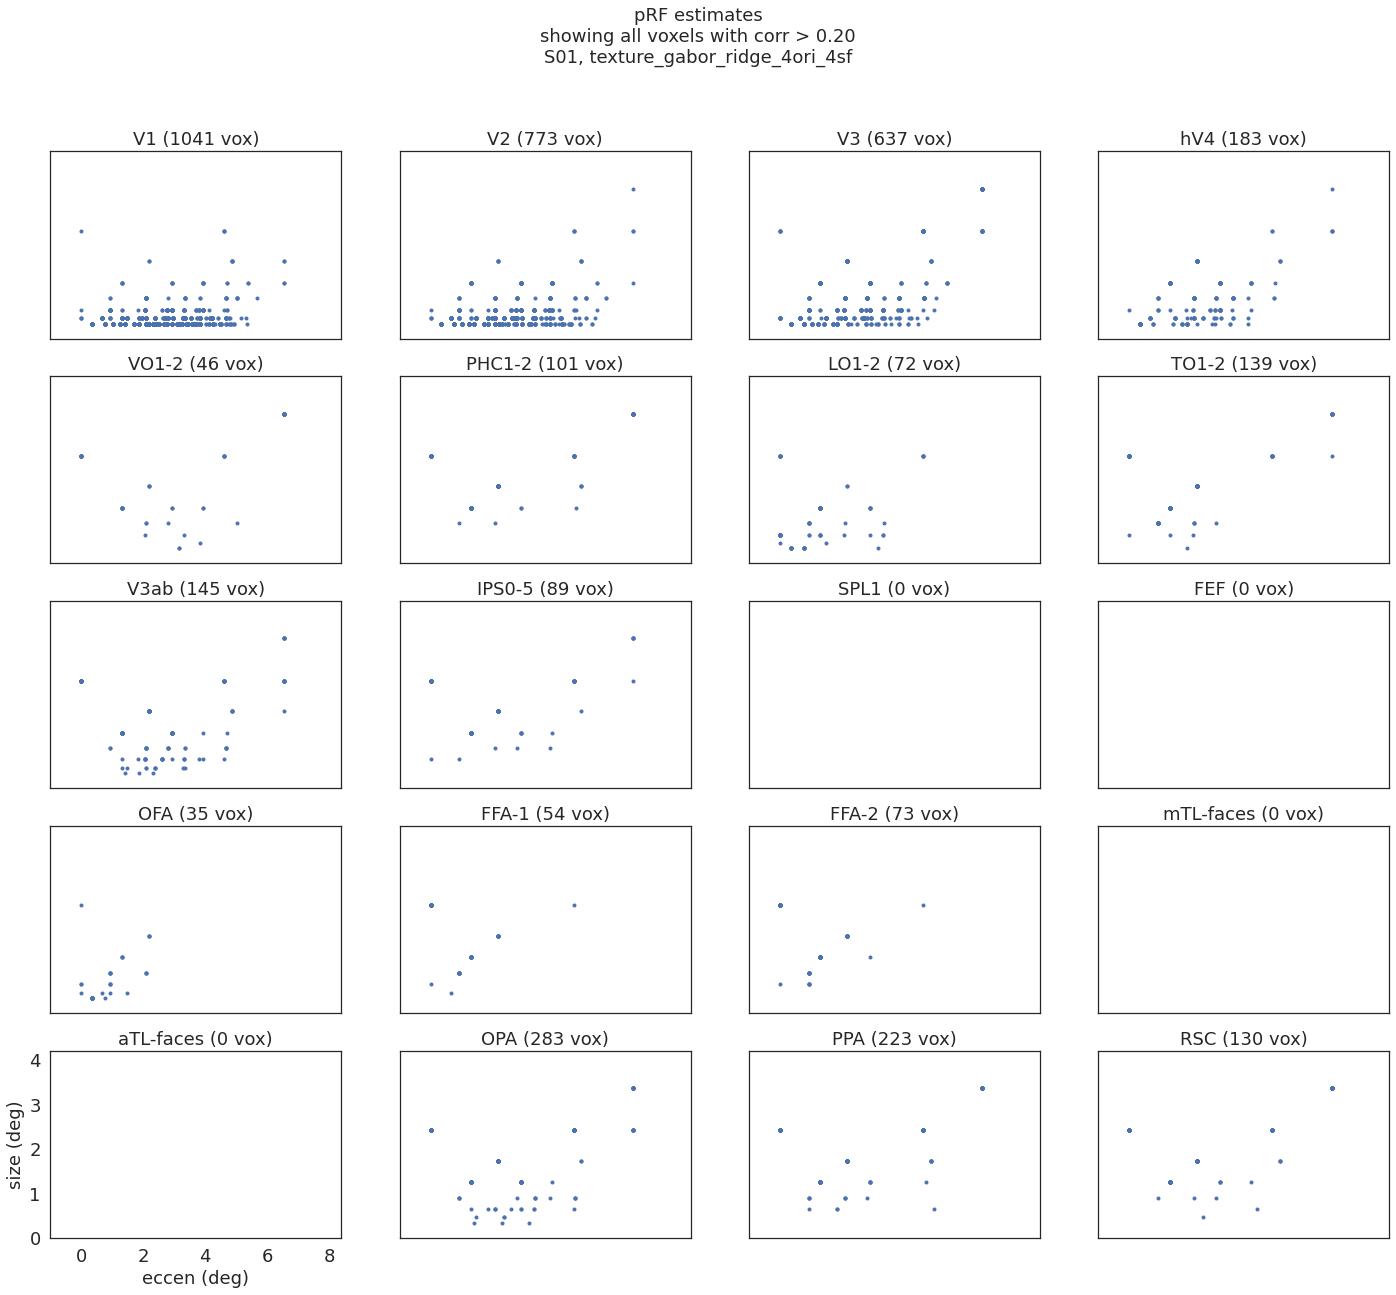

In [24]:
plot_utils.set_all_font_sizes(fs = 18)
spatial_fits.plot_size_vs_eccen(subject, fitting_type, out, cc_cutoff=0.20, fig_save_folder=fig_save_folder)

In [19]:
# Make plots in pycortex for variance partitioning analysis

import cortex

port=33333

pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = analysis_utils.get_r2(out)
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = analysis_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

max_ind = np.argmax(var_expl[:,1:3], axis=1)

maps = [max_ind+1] + [var_expl[:,fi] for fi in range(var_expl.shape[1])]

names = ['Prefered feature type (based on unique var)'] + ve_names

cmaps = ['plasma_r', 'PuBu', 'PuBu', 'PuBu', 'PuBu']
mins = [0,0,0,0,0]
maxes = [2, 0.4, 0.10, 0.10, 0.2]

plot_utils.plot_maps_pycortex(maps, names, subject, out, fitting_type, port, cmaps=cmaps, mins=mins, maxes=maxes)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


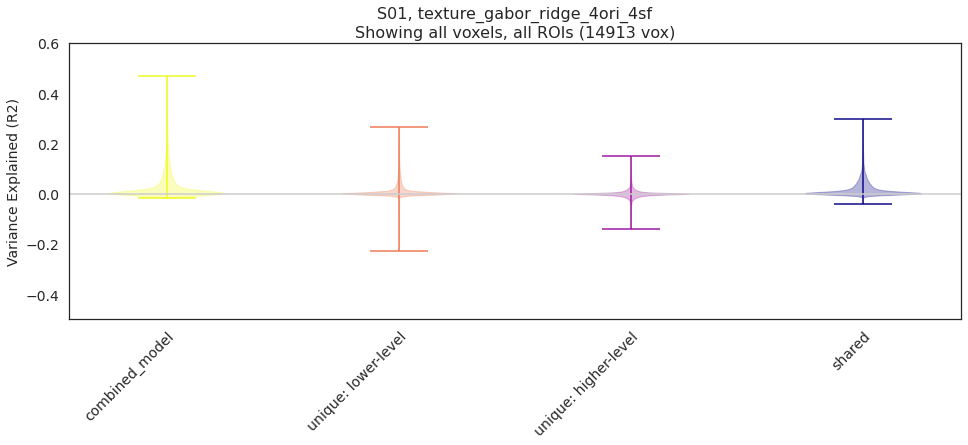

In [114]:
# Plot two-way variance partition

pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = analysis_utils.get_r2(out)
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = analysis_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.50, 0.60])
vp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_allrois.png'))

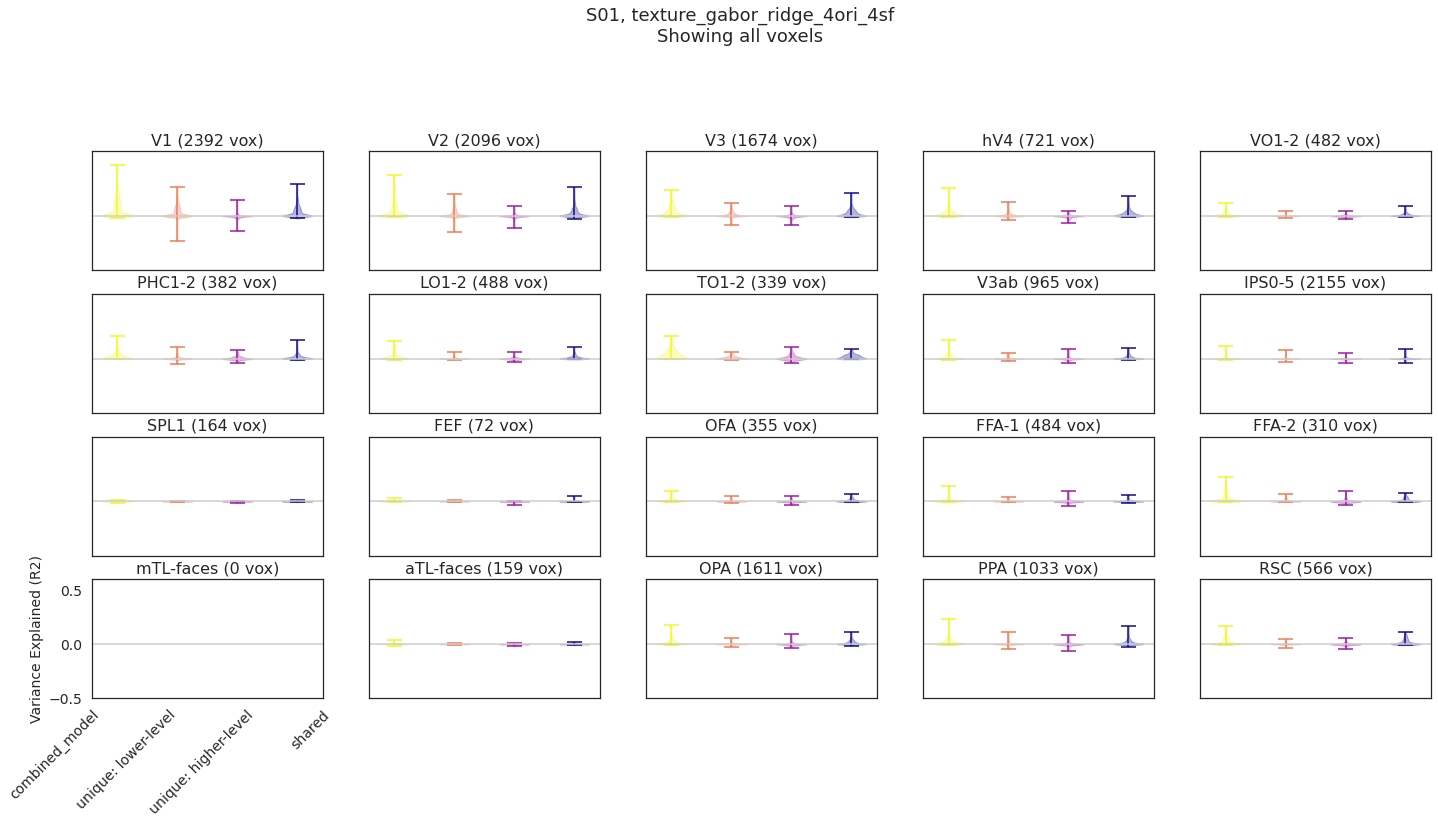

In [116]:

pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = analysis_utils.get_r2(out)
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = analysis_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.50, 0.60])

plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_eachroi.png'))

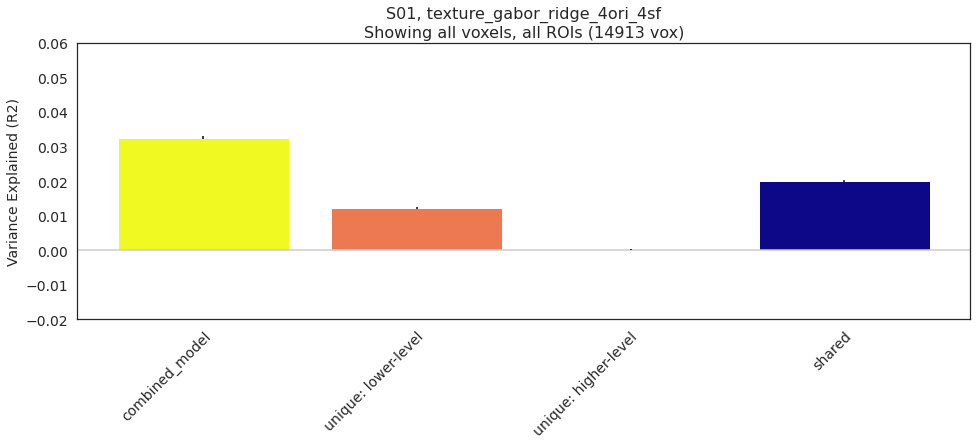

In [115]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = analysis_utils.get_r2(out)
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = analysis_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.06])
bp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_allrois.png'))

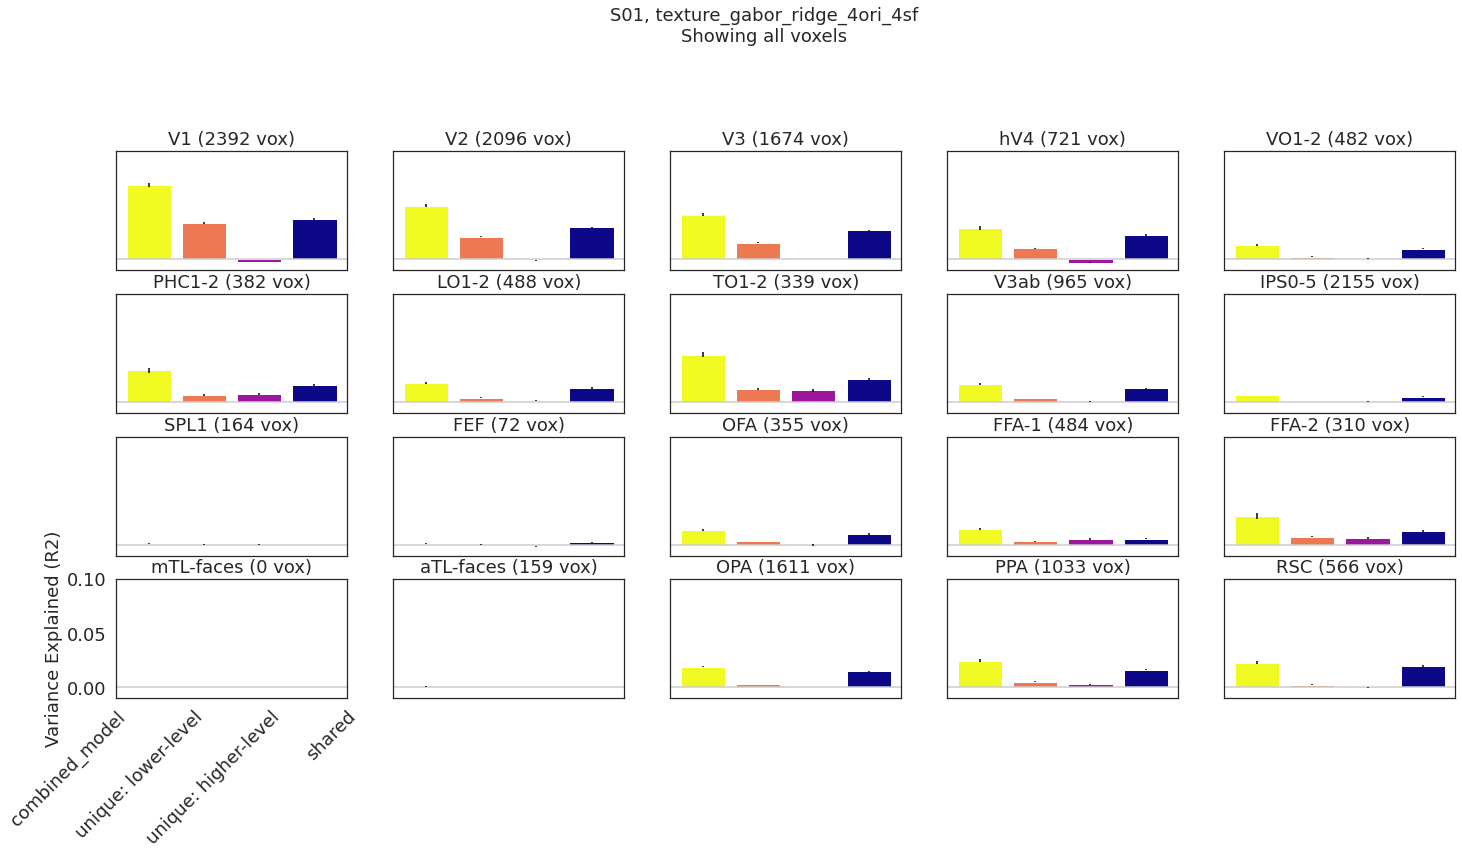

In [17]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = analysis_utils.get_r2(out)
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = analysis_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.10])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_eachroi.png'))

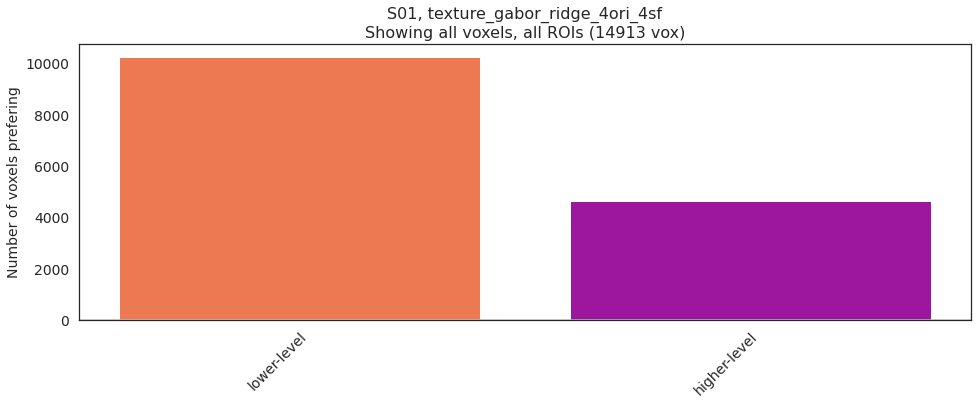

In [18]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = analysis_utils.get_r2(out)
ve_names = [name1,name2]
shared_ab, unique_a, unique_b = analysis_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((unique_a[:,np.newaxis], unique_b[:,np.newaxis]),axis=1)

max_ve  = np.argmax(var_expl, axis=1)
inds2use = np.ones(np.shape(val_r2[:,0]))==1
groups = np.arange(0,var_expl.shape[1])

colors = cm.plasma(np.linspace(0,1,len(ve_names)+2))
colors = np.flipud(colors)
colors = colors[1:,:]

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Number of voxels prefering', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                        np.sum(inds2use)), \
                        horizontal_line_pos=0, ylims=None, \
                         plot_counts=True, groups = groups)
bp.create(data=max_ve[inds2use], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_allrois.png'))

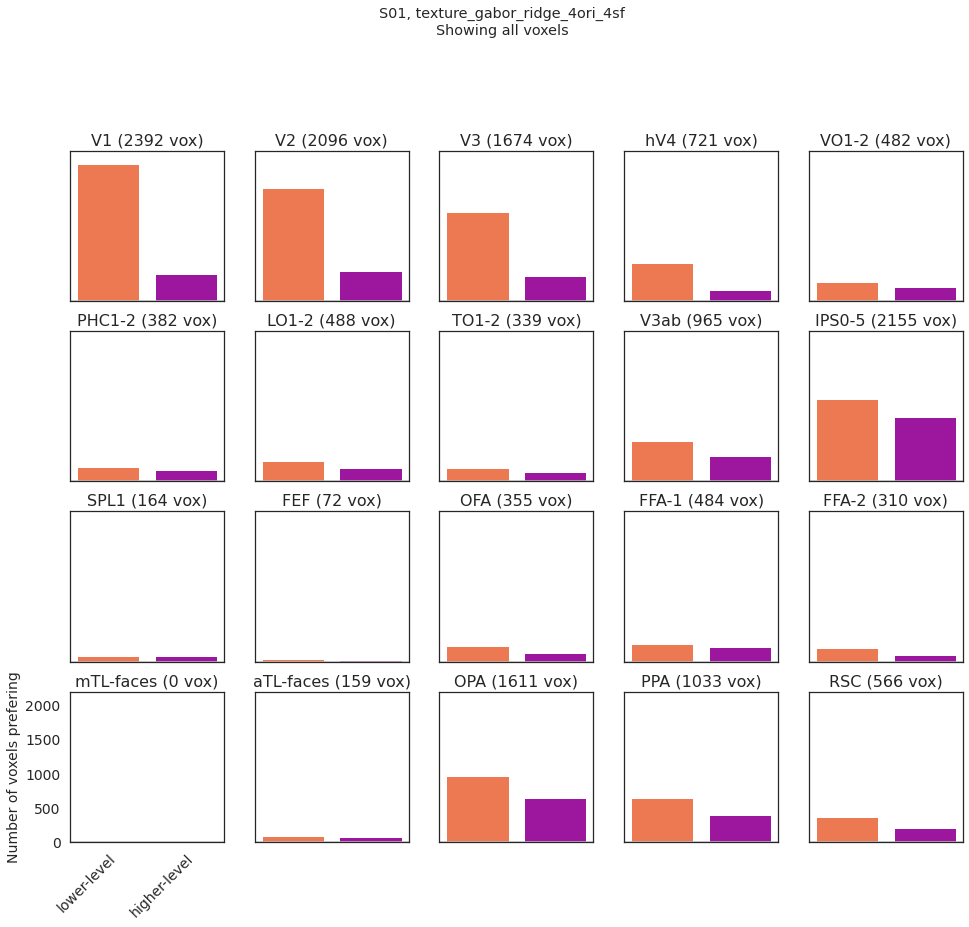

In [16]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = analysis_utils.get_r2(out)
ve_names = [name1,name2]
shared_ab, unique_a, unique_b = analysis_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((unique_a[:,np.newaxis], unique_b[:,np.newaxis]),axis=1)
colors = cm.plasma(np.linspace(0,1,len(ve_names)+2))
colors = np.flipud(colors)
colors = colors[1:,:]

max_ve  = np.expand_dims(np.argmax(var_expl, axis=1), axis=1)
inds2use = np.ones(np.shape(val_r2[:,0]))==1
groups = np.arange(0,var_expl.shape[1])

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Number of voxels prefering', \
                                        horizontal_line_pos=0, ylims=[0,2200], plot_counts=True, groups = groups)
plot_utils.create_roi_subplots(max_ve, inds2use, bp, subject, out, 
                               suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type), \
                   label_just_corner=True, figsize=(16,20))

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_eachroi.png'))

In [12]:
max_ve.shape

(14913,)

In [123]:
inds2use.shape

(14913,)

In [120]:
max_ve.shape

(14913,)

In [118]:
counts.shape

(1, 2)

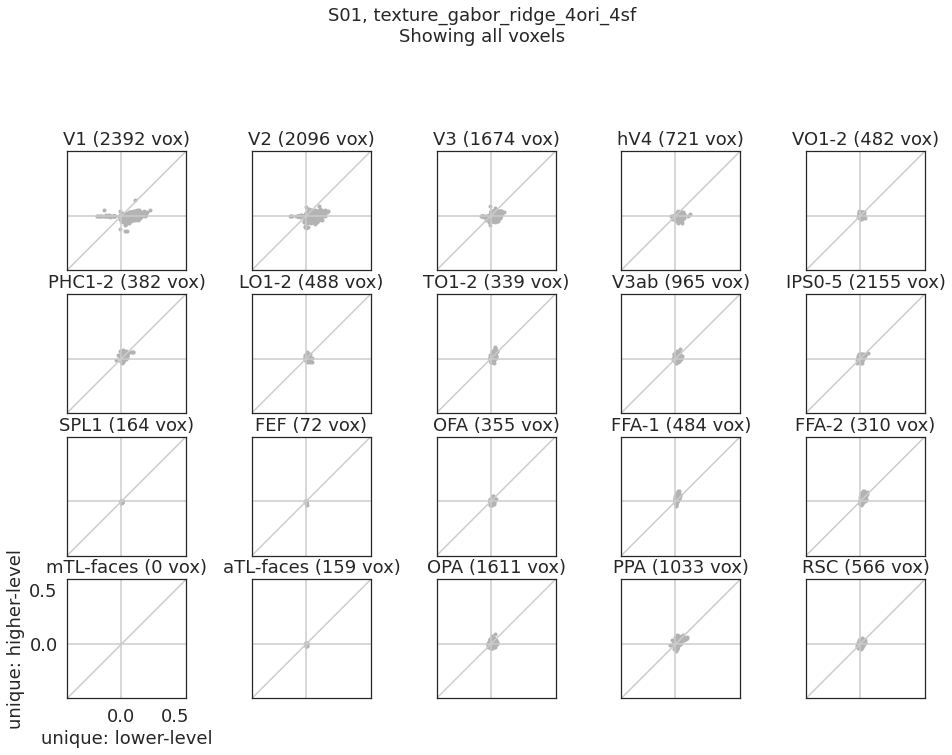

In [18]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = analysis_utils.get_r2(out)
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = analysis_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

var_expl = np.concatenate((unique_a[:,np.newaxis], unique_b[:,np.newaxis]),axis=1)
color = [0.7, 0.7, 0.7]

sp = plot_utils.scatter_plot(color=color, xlabel=ve_names[1], ylabel=ve_names[2], xlims=[-0.5, 0.6], \
                             ylims=[-0.5, 0.6], xticks=[0, 0.5], yticks=[0, 0.5],\
                                                        show_diagonal=True, show_axes=True);
plot_utils.create_roi_subplots(var_expl, inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type), \
                   label_just_corner=True, figsize=(16,20))

plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_scatter_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_scatter_eachroi.png'))

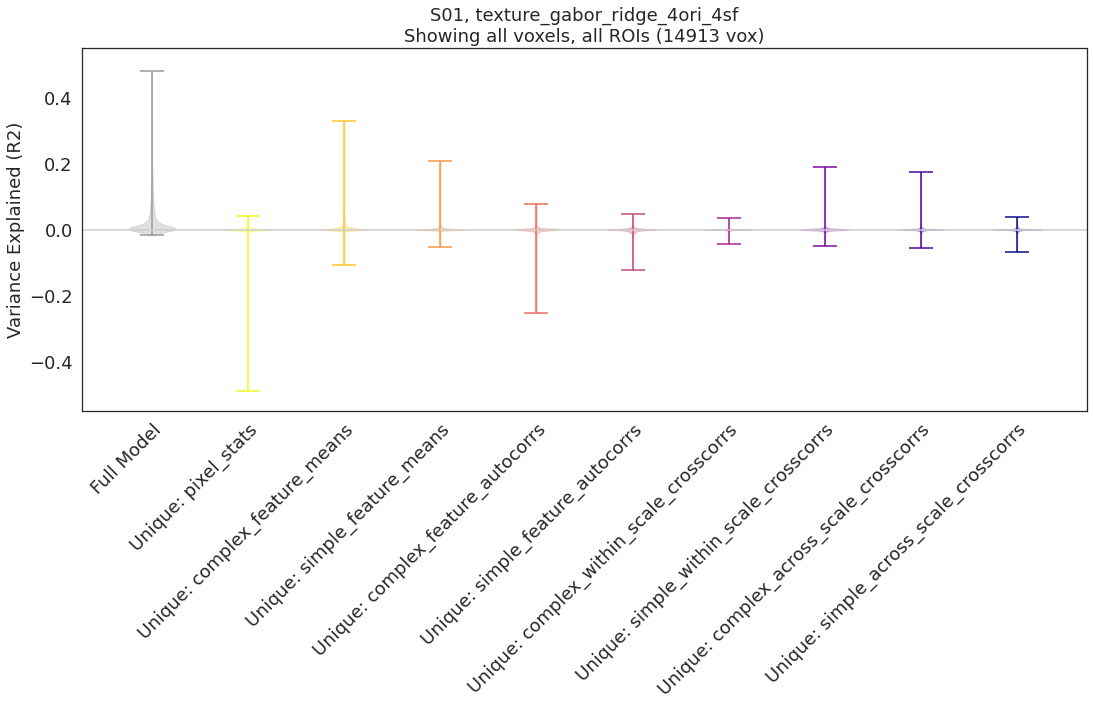

In [109]:
# Plot multi-way variance partition

plot_utils.set_all_font_sizes(fs = 18)
val_r2 = analysis_utils.get_r2(out)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
leave_out_ind = np.where(['leave_out' in name for name in out['partial_version_names']])[0][0]
leave_out_r2 = val_r2[:,leave_out_ind:]
leave_out_names = [out['partial_version_names'][ll][10:] for ll in np.arange(leave_out_ind, len(out['partial_version_names']))]
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,leave_out_r2.shape[1]]) - leave_out_r2
var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Full Model'] + ['Unique: ' + ff for ff in out['feature_info'][1]]

colors = cm.plasma(np.linspace(0,1,len(ve_names)-1))
graycolor = np.array([0.6, 0.6, 0.6, 1])
colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.55, 0.55])
vp.create(data=var_expl[inds2use,:], new_fig=True, figsize=(18,18))

plt.gcf().subplots_adjust(bottom=0.6)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_everytexturefeat_allrois.png'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_everytexturefeat_allrois.pdf'))


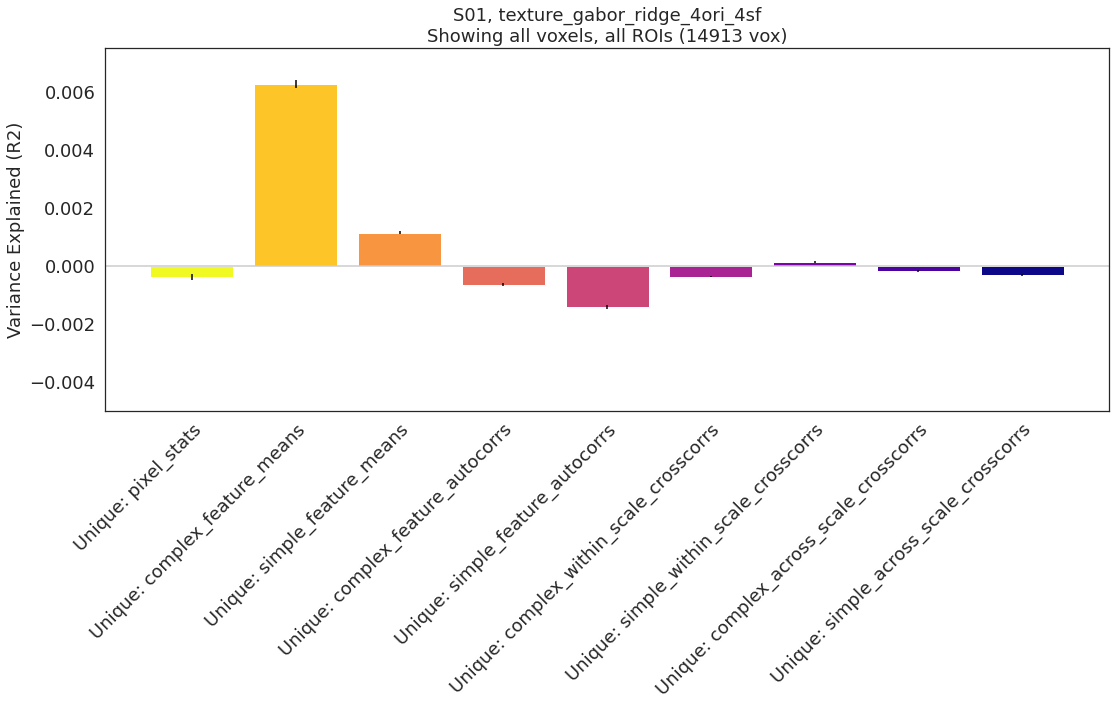

In [110]:
# Plot multi-way variance partition

plot_utils.set_all_font_sizes(fs = 18)
val_r2 = analysis_utils.get_r2(out)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
leave_out_ind = np.where(['leave_out' in name for name in out['partial_version_names']])[0][0]
leave_out_r2 = val_r2[:,leave_out_ind:]
leave_out_names = [out['partial_version_names'][ll][10:] for ll in np.arange(leave_out_ind, len(out['partial_version_names']))]
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,leave_out_r2.shape[1]]) - leave_out_r2
# var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Unique: ' + ff for ff in out['feature_info'][1]]

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)
# graycolor = np.array([0.6, 0.6, 0.6, 1])
# colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.005, 0.0075])
bp.create(data=var_expl[inds2use,:], new_fig=True, figsize=(18,18))

plt.gcf().subplots_adjust(bottom=0.6)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bar_everytexturefeat_allrois.png'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bar_everytexturefeat_allrois.pdf'))


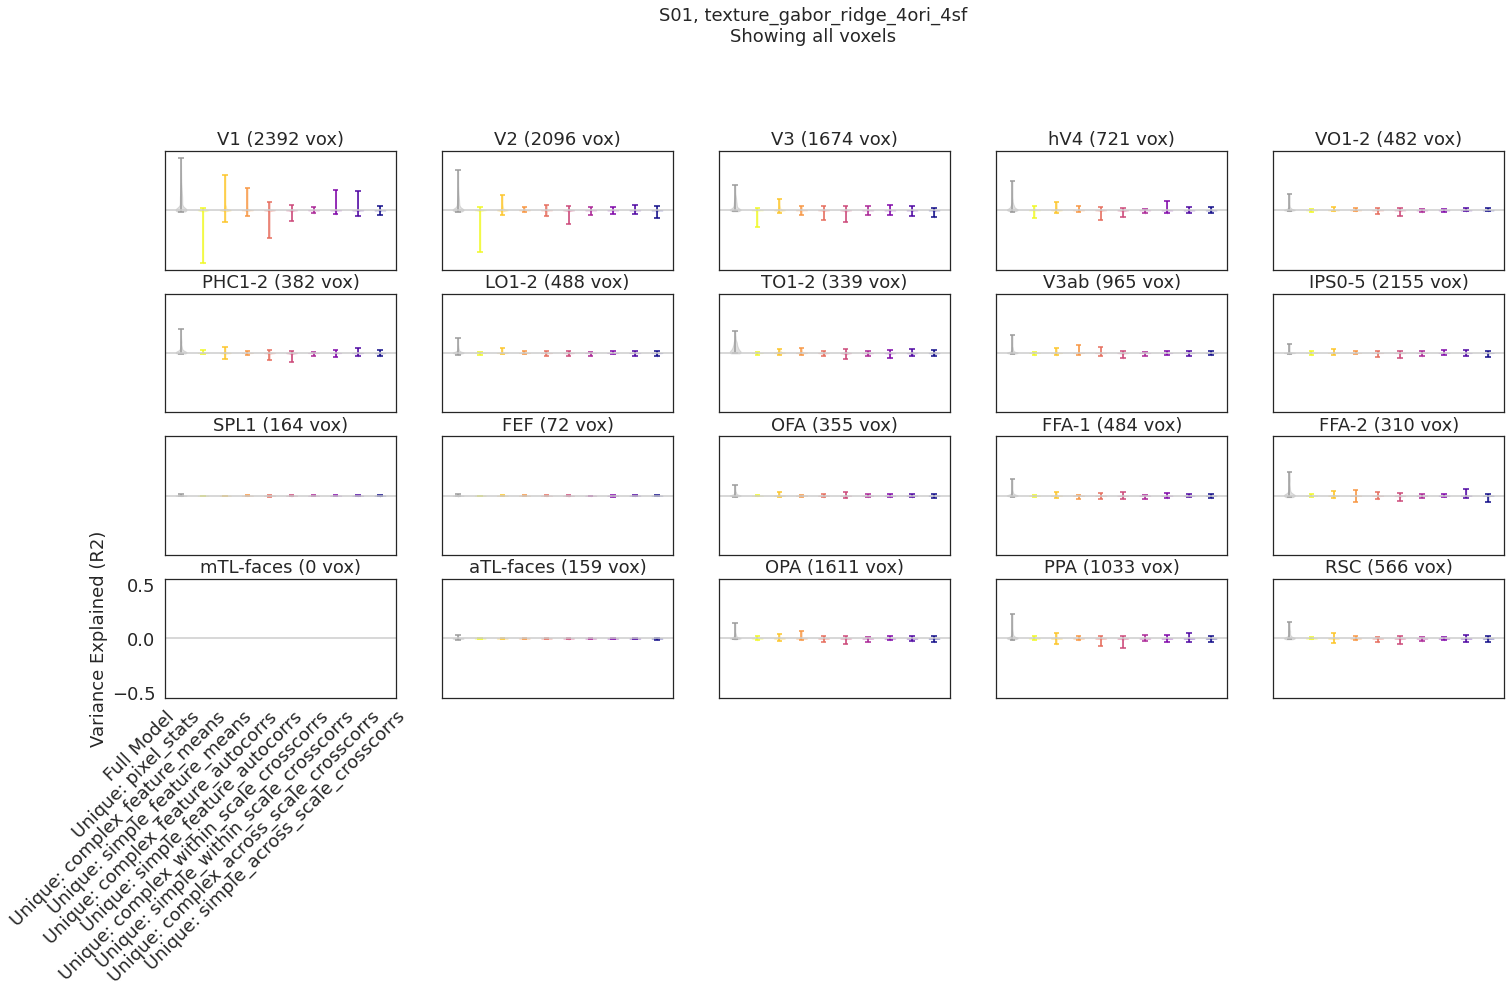

In [102]:
# Plot multi-way variance partition

plot_utils.set_all_font_sizes(fs = 18)
val_r2 = analysis_utils.get_r2(out)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
leave_out_ind = np.where(['leave_out' in name for name in out['partial_version_names']])[0][0]
leave_out_r2 = val_r2[:,leave_out_ind:]
leave_out_names = [out['partial_version_names'][ll][10:] for ll in np.arange(leave_out_ind, len(out['partial_version_names']))]
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,leave_out_r2.shape[1]]) - leave_out_r2
var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Full Model'] + ['Unique: ' + ff for ff in out['feature_info'][1]]

colors = cm.plasma(np.linspace(0,1,len(ve_names)-1))
graycolor = np.array([0.6, 0.6, 0.6, 1])
colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)',\
                            horizontal_line_pos=0, ylims=[-0.55, 0.55])

plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_everytexturefeat_eachroi.png'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_violin_everytexturefeat_eachroi.pdf'))


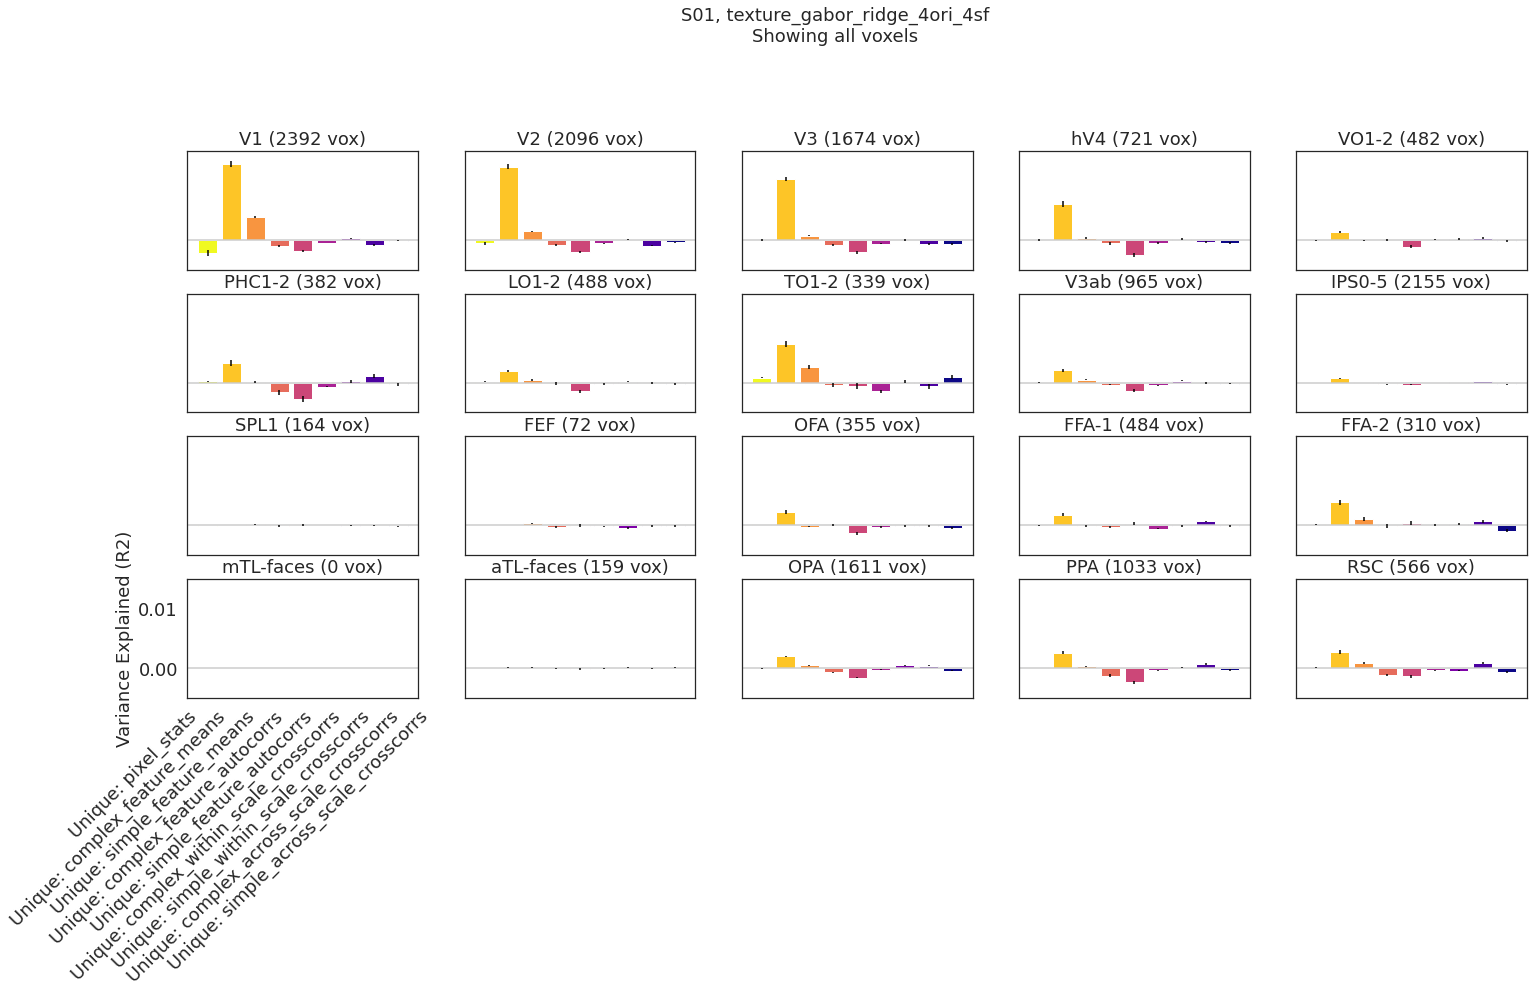

In [103]:
# Plot multi-way variance partition

plot_utils.set_all_font_sizes(fs = 18)
val_r2 = analysis_utils.get_r2(out)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
leave_out_ind = np.where(['leave_out' in name for name in out['partial_version_names']])[0][0]
leave_out_r2 = val_r2[:,leave_out_ind:]
leave_out_names = [out['partial_version_names'][ll][10:] for ll in np.arange(leave_out_ind, len(out['partial_version_names']))]
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,leave_out_r2.shape[1]]) - leave_out_r2
# var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Unique: ' + ff for ff in out['feature_info'][1]]

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)
# graycolor = np.array([0.6, 0.6, 0.6, 1])
# colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)',\
                            horizontal_line_pos=0, ylims=[-0.005, 0.015])

plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, \
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_everytexturefeat_eachroi.png'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_everytexturefeat_eachroi.pdf'))


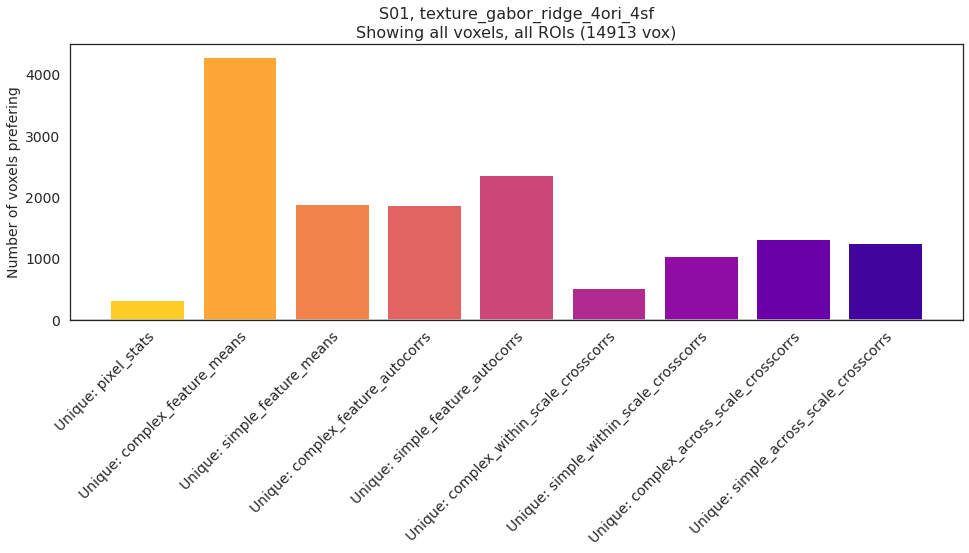

In [33]:

val_r2 = analysis_utils.get_r2(out)

leave_out_ind = np.where(['leave_out' in name for name in out['partial_version_names']])[0][0]
leave_out_r2 = val_r2[:,leave_out_ind:]
leave_out_names = [out['partial_version_names'][ll][10:] for ll in np.arange(leave_out_ind, len(out['partial_version_names']))]
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,leave_out_r2.shape[1]]) - leave_out_r2
# var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Unique: ' + ff for ff in out['feature_info'][1]]

max_ve  = np.argmax(var_expl, axis=1)
inds2use = np.ones(np.shape(val_r2[:,0]))==1
groups = np.arange(0,var_expl.shape[1])

colors = cm.plasma(np.linspace(0,1,len(ve_names)+2))
colors = np.flipud(colors)
colors = colors[1:,:]

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Number of voxels prefering', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                        np.sum(inds2use)), \
                        horizontal_line_pos=0, ylims=None, \
                         plot_counts=True, groups = groups)
bp.create(data=max_ve[inds2use], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_everytexturefeature_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_everytexturefeature_allrois.png'))

In [31]:
np.where(['leave_out' in name for name in out['partial_version_names']])[0][0]

10

In [29]:
val_r2.shape

(14913, 3)

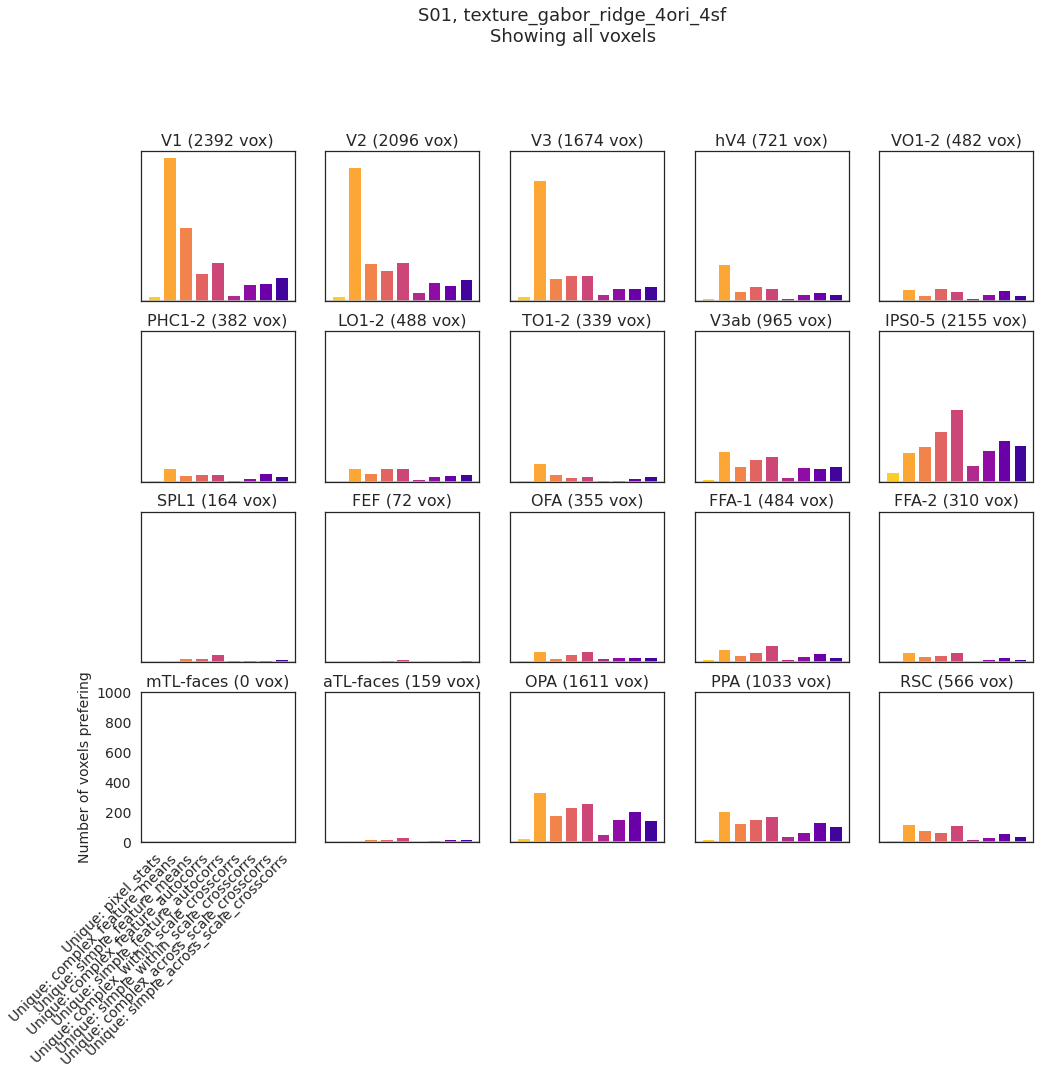

In [40]:

val_r2 = analysis_utils.get_r2(out)

leave_out_ind = np.where(['leave_out' in name for name in out['partial_version_names']])[0][0]
leave_out_r2 = val_r2[:,leave_out_ind:]
leave_out_names = [out['partial_version_names'][ll][10:] for ll in np.arange(leave_out_ind, len(out['partial_version_names']))]
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,leave_out_r2.shape[1]]) - leave_out_r2
# var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Unique: ' + ff for ff in out['feature_info'][1]]


colors = cm.plasma(np.linspace(0,1,len(ve_names)+2))
colors = np.flipud(colors)
colors = colors[1:,:]

max_ve  = np.expand_dims(np.argmax(var_expl, axis=1), axis=1)
inds2use = np.ones(np.shape(val_r2[:,0]))==1
groups = np.arange(0,var_expl.shape[1])

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Number of voxels prefering', \
                                        horizontal_line_pos=0, ylims=[0,1000], plot_counts=True, groups = groups)
plot_utils.create_roi_subplots(max_ve, inds2use, bp, subject, out, 
                               suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type), \
                   label_just_corner=True, figsize=(16,20))

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_everytexturefeature_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_everytexturefeature_eachroi.png'))